# Centralized Radiomics Signature Learning Jupyter Notebook

#### *Method is based on Shi+, Zhovannik+, Dankers et al *


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index#, k_fold_cross_validation
from sklearn.preprocessing import  StandardScaler#, MinMaxScaler, RobustScaler
import scipy
from sklearn.utils import resample
from scipy.stats import wilcoxon

%matplotlib inline

## Data load and pre-processing

In [2]:
# read the data

# training set
df_lung1 = pd.read_excel("Lung1_data_DistRad.xlsx")

# validation set
df_lung2 = pd.read_excel("Lung2_data_DistRad.xlsx")

In [3]:
predictors = [   
    "original_firstorder_Energy",
    "original_shape_Compactness2",
    "original_glrlm_GrayLevelNonUniformity",
    "wavelet-HLH_glrlm_GrayLevelNonUniformity"]

# scaler for data pre-processing
scaler = StandardScaler() #None

# False - scaling based on the training set (Lung1); True - separate Lung1-Lung2 scaling
separate_scaling = True #False

if scaler != None:
    # scale Lung1
    df_lung1[predictors] = scaler.fit_transform(np.log10(df_lung1[predictors]))
    #scale Lung2
    if separate_scaling:
        df_lung2[predictors] = scaler.fit_transform(np.log10(df_lung2[predictors]))
    else:
        df_lung2[predictors] = scaler.transform(np.log10(df_lung2[predictors]))

# True - drop samples with a feature value not in 6 * sigma confidence interval
drop_outliers = False

if drop_outliers:
    df_lung2 = df_lung2.loc[np.where(((np.abs(stats.zscore(df_lung2[predictors])) < 3) * 1).sum(axis=1) == 4)]
    df_lung2 = pd.DataFrame(data=df_lung2,
                             index=list(range(df_lung2.shape[0])))
    df_lung1 = df_lung1.loc[np.where(((np.abs(stats.zscore(df_lung1[predictors])) < 3) * 1).sum(axis=1) == 4)]
    df_lung1 = pd.DataFrame(data=df_lung1,
                             index=list(range(df_lung1.shape[0])))

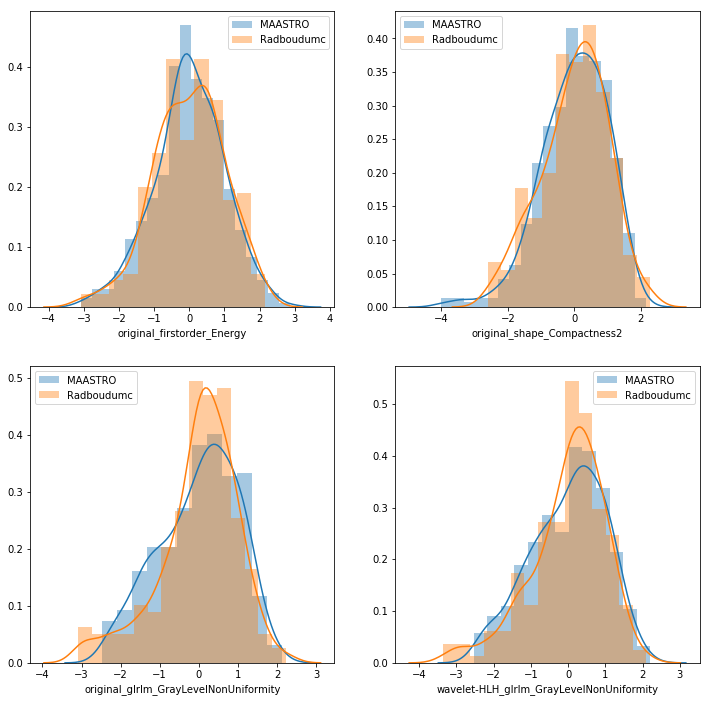

In [4]:
# data visualization
plt.figure(figsize=(12, 12))

ax1 = plt.subplot(2, 2, 1)
sns.distplot(df_lung1[predictors[0]], ax=ax1)
sns.distplot(df_lung2[predictors[0]], ax=ax1)
plt.legend(["MAASTRO", "Radboudumc"])

ax2 = plt.subplot(2, 2, 2)
sns.distplot(df_lung1[predictors[1]], ax=ax2)
sns.distplot(df_lung2[predictors[1]], ax=ax2)
plt.legend(["MAASTRO", "Radboudumc"])

ax3 = plt.subplot(2, 2, 3)
sns.distplot(df_lung1[predictors[2]], ax=ax3)
sns.distplot(df_lung2[predictors[2]], ax=ax3)
plt.legend(["MAASTRO", "Radboudumc"])

ax4 = plt.subplot(2, 2, 4)
sns.distplot(df_lung1[predictors[3]], ax=ax4)
sns.distplot(df_lung2[predictors[3]], ax=ax4)
plt.legend(["MAASTRO", "Radboudumc"])

## Modeling

In [5]:
# cox fitter
cox = CoxPHFitter(penalizer=0)

# model fit
cox.fit(df_lung1[predictors + ["Survival.time", "deadstatus.event"]].dropna(axis=0),
        duration_col="Survival.time", event_col="deadstatus.event")

# split median
threshold_lung1_median = cox.predict_survival_function(df_lung1).loc[cox.predict_survival_function(df_lung1).index[20]].median()

# split the training set
threshold_lung1 = cox.predict_survival_function(df_lung1).loc[cox.predict_survival_function(df_lung1).index[20]]
df_lung1_moremed = df_lung1.loc[np.where(threshold_lung1 > threshold_lung1_median)]
df_lung1_lessmed = df_lung1.loc[np.where(threshold_lung1 <= threshold_lung1_median)]

#split the validation set
threshold_lung2 = cox.predict_survival_function(df_lung2).loc[cox.predict_survival_function(df_lung2).index[20]]
df_lung2_moremed = df_lung2.loc[np.where(threshold_lung2 > threshold_lung1_median)]
df_lung2_lessmed = df_lung2.loc[np.where(threshold_lung2 <= threshold_lung1_median)]

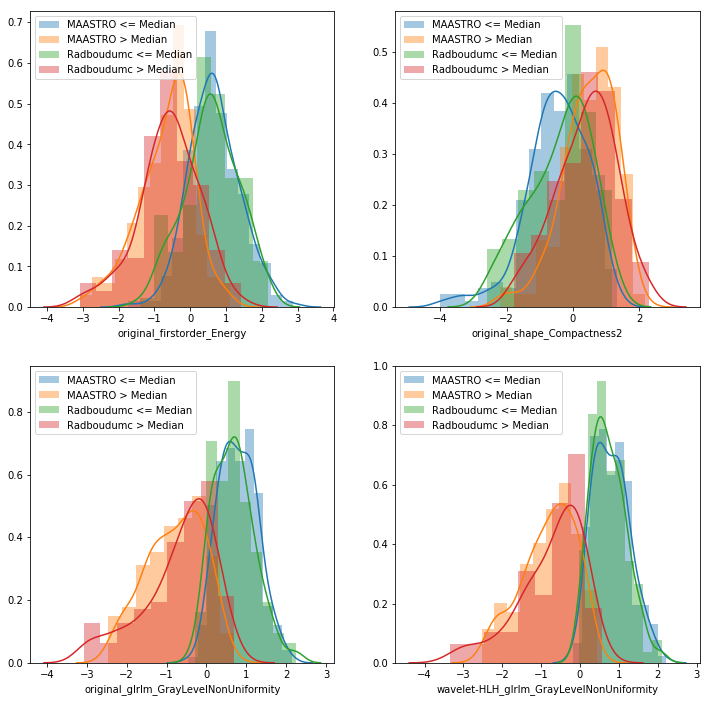

In [6]:
# data visualization after the split
plt.figure(figsize=(12, 12))

ax1 = plt.subplot(2, 2, 1)
sns.distplot(df_lung1_lessmed[predictors[0]], ax=ax1)
sns.distplot(df_lung1_moremed[predictors[0]], ax=ax1)
sns.distplot(df_lung2_lessmed[predictors[0]], ax=ax1)
sns.distplot(df_lung2_moremed[predictors[0]], ax=ax1)
plt.legend(["MAASTRO <= Median", "MAASTRO > Median", "Radboudumc <= Median", "Radboudumc > Median"])

ax2 = plt.subplot(2, 2, 2)
sns.distplot(df_lung1_lessmed[predictors[1]], ax=ax2)
sns.distplot(df_lung1_moremed[predictors[1]], ax=ax2)
sns.distplot(df_lung2_lessmed[predictors[1]], ax=ax2)
sns.distplot(df_lung2_moremed[predictors[1]], ax=ax2)
plt.legend(["MAASTRO <= Median", "MAASTRO > Median", "Radboudumc <= Median", "Radboudumc > Median"])

ax3 = plt.subplot(2, 2, 3)
sns.distplot(df_lung1_lessmed[predictors[2]], ax=ax3)
sns.distplot(df_lung1_moremed[predictors[2]], ax=ax3)
sns.distplot(df_lung2_lessmed[predictors[2]], ax=ax3)
sns.distplot(df_lung2_moremed[predictors[2]], ax=ax3)
plt.legend(["MAASTRO <= Median", "MAASTRO > Median", "Radboudumc <= Median", "Radboudumc > Median"])

ax4 = plt.subplot(2, 2, 4)
sns.distplot(df_lung1_lessmed[predictors[3]], ax=ax4)
sns.distplot(df_lung1_moremed[predictors[3]], ax=ax4)
sns.distplot(df_lung2_lessmed[predictors[3]], ax=ax4)
sns.distplot(df_lung2_moremed[predictors[3]], ax=ax4)
plt.legend(["MAASTRO <= Median", "MAASTRO > Median", "Radboudumc <= Median", "Radboudumc > Median"])

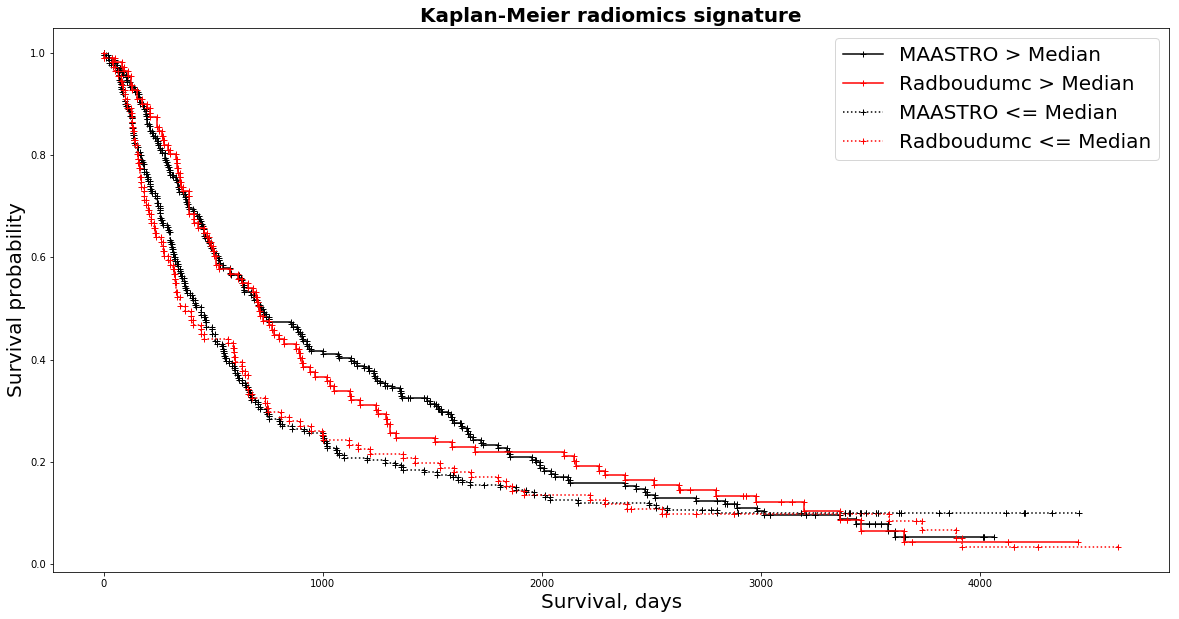

In [7]:
# Kaplan-Meier fitter
kmf = KaplanMeierFitter()

plt.figure(figsize=(20,10))
#plt.xlim(0, 1400)
plt.xlabel("Survival, days", {"fontsize": 20})
plt.ylabel("Survival probability", {"fontsize": 20})
plt.title("Kaplan-Meier radiomics signature", {"fontsize": 20, "fontweight": "bold"})


kmf.fit(df_lung1_moremed["Survival.time"], event_observed=df_lung1_moremed["deadstatus.event"])
plt.step(kmf.survival_function_, "k+")

kmf.fit(df_lung2_moremed["Survival.time"], event_observed=df_lung2_moremed["deadstatus.event"])
plt.step(kmf.survival_function_, "r+")


kmf.fit(df_lung1_lessmed["Survival.time"], event_observed=df_lung1_lessmed["deadstatus.event"])
plt.step(kmf.survival_function_, "k+", LineStyle=":")

kmf.fit(df_lung2_lessmed["Survival.time"], event_observed=df_lung2_lessmed["deadstatus.event"])
plt.step(kmf.survival_function_, "r+", LineStyle=":")

plt.legend(["MAASTRO > Median", "Radboudumc > Median", "MAASTRO <= Median", "Radboudumc <= Median"], prop={"size":20})

## Evaluation and summary:

- Log-rank test
- Concordance index
- Model Summary

In [8]:
# log-rank test Lung1
results = logrank_test(df_lung1_moremed["Survival.time"],
                       df_lung1_lessmed["Survival.time"],
                       df_lung1_moremed["deadstatus.event"],
                       df_lung1_lessmed["deadstatus.event"], alpha=.95)

print("### LUNG1 ###")
results.print_summary()

# log-rank test Lung2
results = logrank_test(df_lung2_moremed["Survival.time"], df_lung2_lessmed["Survival.time"],
                       df_lung2_moremed["deadstatus.event"], df_lung2_lessmed["deadstatus.event"], alpha=.95)

print("### LUNG2 ###")
results.print_summary()

# Concordance index
CI1 = concordance_index(df_lung1["Survival.time"], 
                        cox.predict_expectation(df_lung1), 
                        df_lung1["deadstatus.event"])

CI2 = concordance_index(df_lung2["Survival.time"], 
                        cox.predict_expectation(df_lung2), 
                        df_lung2["deadstatus.event"])

print(f"\n#################\nConcordance index in \nLung1: {CI1:.4}\nLung2: {CI2:.4}\n#################\n")

cox.summary

### LUNG1 ###

t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p    
        7.2752 0.0070  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
### LUNG2 ###

t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        4.2926 0.0383  *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

#################
Concordance index in 
Lung1: 0.5834
Lung2: 0.5827
#################



,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
original_firstorder_Energy,0.051739,1.053100,0.099595,0.519487,0.603421,-0.143465,0.246942
original_shape_Compactness2,-0.015085,0.985028,0.057946,-0.260323,0.794615,-0.128657,0.098488
original_glrlm_GrayLevelNonUniformity,0.076396,1.079390,0.429572,0.177843,0.858846,-0.765549,0.918342
wavelet-HLH_glrlm_GrayLevelNonUniformity,0.078805,1.081993,0.469709,0.167774,0.866761,-0.841808,0.999417


### *Optional*: Concordance Index Evaluation with Bootstrapping

Lung2 dataset is used to create 100 new bootstrapped datasets. The size of a new dataset is 80% the size of the original Lung2 dataset. Then each new dataset is used to define its CI.

Wilcoxon results - if CI is equal to 0.5?

Wilcox method: [1.0, 4.0161556854627e-18]
Pratt method: [1.0, 4.0161556854627e-18]
Zsplit method: [1.0, 4.0161556854627e-18]
Confidence inteval for CI: [0.5267080333792442, 0.6358929507021999]


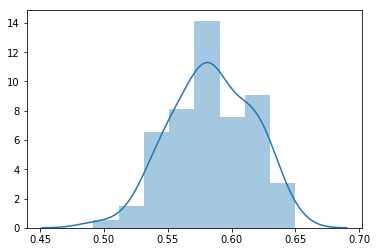

In [9]:
times = 100
CI_scores = []


for i in range(times):
    # aggregate bootstrapped data
    boot = resample(df_lung2, replace=True, n_samples= np.round(0.5 * df_lung2.shape[0]).astype(int), random_state=i)
    CI_scores.append(concordance_index(boot["Survival.time"], 
                  cox.predict_expectation(boot[predictors].values), 
                  boot["deadstatus.event"]))

CI_scores = np.array(CI_scores)

sns.distplot(CI_scores)
print("Wilcoxon results - if CI is equal to 0.5?\n")
print("Wilcox method:", list(wilcoxon(CI_scores, 0.5 * np.ones(CI_scores.shape), zero_method="wilcox")))
print("Pratt method:", list(wilcoxon(CI_scores, 0.5 * np.ones(CI_scores.shape), zero_method="pratt")))
print("Zsplit method:", list(wilcoxon(CI_scores, 0.5 * np.ones(CI_scores.shape), zero_method="zsplit")))


def confidence_interval(data, confidence=0.95):
    p = ((1.0-confidence)/2.0) * 100
    lower = max(0.0, np.percentile(CI_scores, p))
    p = (confidence+((1.0-confidence)/2.0)) * 100
    upper = min(1.0, np.percentile(CI_scores, p))
    return np.mean(data), lower, upper

print(f"Confidence inteval for CI: {list(confidence_interval(CI_scores))[1:]}")
